# **Individual Assignment: Liquor Sales**

## Data Processing

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import folium
from matplotlib.ticker import FuncFormatter
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load the dataset
liquor_df = pd.read_csv(
    r"C:\Users\PC\Desktop\big-data\data\liqoir_sales\Iowa_Liquor_Sales.csv",
    dtype={"Zip Code": str},
    low_memory=False
)

In [3]:
# Drop redundant columns
cols_to_drop = ['County Number', 'Volume Sold (Gallons)', 'Invoice/Item Number', 'Address', 'Zip Code',  'Vendor Name',  'Item Description',
                'Store Number', 'Vendor Number', 'Item Number', 'Pack', 'Volume Sold (Liters)', 'Category']
liquor_df.drop(columns=cols_to_drop, inplace=True)

In [4]:
# Ensure date column is datetime
liquor_df['Date'] = pd.to_datetime(liquor_df['Date'], errors='coerce')

# Normalize string casing for consistent grouping
liquor_df['Store Name'] = liquor_df['Store Name'].str.title().str.strip()
liquor_df['City'] = liquor_df['City'].str.title().str.strip()
liquor_df['County'] = liquor_df['County'].str.upper().str.strip()
liquor_df['Category Name'] = liquor_df['Category Name'].str.title().str.strip()

# Convert price-related columns to float
liquor_df['State Bottle Cost'] = liquor_df['State Bottle Cost'].replace('[\$,]', '', regex=True).astype(float)
liquor_df['State Bottle Retail'] = liquor_df['State Bottle Retail'].replace('[\$,]', '', regex=True).astype(float)
liquor_df['Sale (Dollars)'] = liquor_df['Sale (Dollars)'].replace('[\$,]', '', regex=True).astype(float)

In [5]:
liquor_df.dtypes

Date                   datetime64[ns]
Store Name                     object
City                           object
Store Location                 object
County                         object
Category Name                  object
Bottle Volume (ml)              int64
State Bottle Cost             float64
State Bottle Retail           float64
Bottles Sold                    int64
Sale (Dollars)                float64
dtype: object

In [6]:
liquor_df

,Date,Store Name,City,Store Location,County,Category Name,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)
0,2015-11-20,Keokuk Spirits,Keokuk,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",LEE,NaN,750,18.09,27.14,6,162.84
1,2015-11-21,Ding'S Honk And Holler,Clarinda,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",PAGE,NaN,750,18.09,27.14,12,325.68
2,2015-11-16,Quicker Liquor Store,Fort Madison,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",LEE,NaN,150,6.40,9.60,2,19.20
3,2015-11-04,Hy-Vee Food Store #2 / Iowa City,Iowa City,812 S 1ST AVE\nIOWA CITY 52240\n,JOHNSON,NaN,1750,35.55,53.34,3,160.02
4,2015-11-17,Twin Town Liquor,Toledo,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",TAMA,NaN,150,6.40,9.60,2,19.20
...,...,...,...,...,...,...,...,...,...,...,...
12591072,2017-10-31,Stammer Liquor Corp,Sheldon,"615 2nd Ave\nSheldon 51201\n(43.184614, -95.85...",OBRIEN,Cocktails /Rtd,800,8.00,12.00,3,12.00
12591073,2017-10-31,Stammer Liquor Corp,Sheldon,"615 2nd Ave\nSheldon 51201\n(43.184614, -95.85...",OBRIEN,Straight Bourbon Whiskies,750,27.48,41.22,2,41.22
12591074,2017-10-31,Stammer Liquor Corp,Sheldon,"615 2nd Ave\nSheldon 51201\n(43.184614, -95.85...",OBRIEN,Bottled In Bond Bourbon,750,24.98,37.47,2,37.47
12591075,2017-10-31,Stammer Liquor Corp,Sheldon,"615 2nd Ave\nSheldon 51201\n(43.184614, -95.85...",OBRIEN,Straight Bourbon Whiskies,750,22.49,33.74,2,33.74


In [7]:
# Inspect the dataset

# 1. Date range
date_min = liquor_df['Date'].min()
date_max = liquor_df['Date'].max()
print("Date range:", date_min.date(), "to", date_max.date())

# 2. Unique counties
counties = sorted(liquor_df['County'].dropna().unique())
print("Number of counties:", len(counties))
print("Example counties:", counties[:10])

# 3. Unique cities
cities = sorted(liquor_df['City'].dropna().unique())
print("Number of cities:", len(cities))
print("Example cities:", cities[:10])

# 4. Unique Bottle Sizes
bottle_sizes = sorted(liquor_df['Bottle Volume (ml)'].dropna().unique())
print("Unique bottle sizes (ml):", len(bottle_sizes))
print("Example bottle sizes:", bottle_sizes[:49])

# 5. Unique Stores
stores = sorted(liquor_df['Store Name'].dropna().unique())
print("Number of unique stores:", len(stores))
print("Example stores:", stores[:5])

Date range: 2012-01-03 to 2017-10-31
Number of counties: 103
Example counties: ['ADAIR', 'ADAMS', 'ALLAMAKEE', 'APPANOOSE', 'AUDUBON', 'BENTON', 'BLACK HAWK', 'BOONE', 'BREMER', 'BUCHANAN']
Number of cities: 416
Example cities: ['Ackley', 'Adair', 'Adel', 'Afton', 'Akron', 'Albert City', 'Albia', 'Albion', 'Alburnett', 'Alden']
Unique bottle sizes (ml): 49
Example bottle sizes: [np.int64(0), np.int64(12), np.int64(15), np.int64(50), np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(301), np.int64(375), np.int64(400), np.int64(500), np.int64(502), np.int64(600), np.int64(603), np.int64(750), np.int64(800), np.int64(850), np.int64(900), np.int64(950), np.int64(1000), np.int64(1125), np.int64(1200), np.int64(1500), np.int64(1508), np.int64(1750), np.int64(1800), np.int64(1850), np.int64(1950), np.int64(2000), np.int64(2250), np.int64(2400), np.int64(2550), np.int64(3000), np.int64(3500), np.int64(3600), np.int64(3900), np.int64(4500), np.int64(4800), np.i

In [8]:
# Count entries with very large bottle sizes
above_1750 = liquor_df[liquor_df['Bottle Volume (ml)'] > 1750]
above_4500 = liquor_df[liquor_df['Bottle Volume (ml)'] > 4500]

print("Number of rows with bottle size > 1750ml:", len(above_1750))
print("Number of rows with bottle size > 4500ml:", len(above_4500))

Number of rows with bottle size > 1750ml: 65973
Number of rows with bottle size > 4500ml: 1145


In [9]:
print("Bottle size distribution (count of rows per size):")
print(liquor_df['Bottle Volume (ml)'].value_counts().sort_index())

Bottle size distribution (count of rows per size):
Bottle Volume (ml)
0              14
12              1
15              1
50           3906
100         39299
150           592
200        440717
250           727
300         61639
301           130
375       1224058
400          1004
500        523506
502           349
600        141093
603           187
750       5719505
800         13723
850          1235
900           708
950           427
1000      1787513
1125          303
1200        13949
1500          112
1508            3
1750      2550403
1800           29
1850          762
1950          516
2000           23
2250          143
2400         4600
2550           42
3000        58173
3500          301
3600          161
3900           29
4500           49
4800          476
6000          603
7580            1
9000            3
31500          24
140000          8
180000          3
189000          2
225000          1
378000         24
Name: count, dtype: int64


In [10]:
# Filter out abnormal bottle sizes
liquor_df = liquor_df[
    (liquor_df['Bottle Volume (ml)'] >= 50) &
    (liquor_df['Bottle Volume (ml)'] <= 1750)
]

In [11]:
# Define final merge mapping
merge_map = {
    301: 300,
    502: 500,
    603: 600,
    950: 1000,
    1125: 1200,
    850: 800,
    400: 375 
}

# Apply merging
liquor_df.loc[:, 'Bottle Volume (ml)'] = liquor_df['Bottle Volume (ml)'].replace(merge_map)

# Explicitly drop unwanted sizes
explicit_drops = {900, 1500, 1508, 150, 250}
liquor_df = liquor_df[~liquor_df['Bottle Volume (ml)'].isin(explicit_drops)]

# Drop rare sizes (<500 rows), unless preserved
preserved_sizes = {50, 100, 200, 300, 375, 500, 600, 750, 800, 1000, 1200, 1750}
size_counts = liquor_df['Bottle Volume (ml)'].value_counts()
to_drop = [size for size in size_counts.index if size_counts[size] < 500 and size not in preserved_sizes]
liquor_df = liquor_df[~liquor_df['Bottle Volume (ml)'].isin(to_drop)]

# Show final result
print("Cleaned bottle size distribution:")
print(liquor_df['Bottle Volume (ml)'].value_counts().sort_index())

Cleaned bottle size distribution:
Bottle Volume (ml)
50         3906
100       39299
200      440717
300       61769
375     1225062
500      523855
600      141280
750     5719505
800       14958
1000    1787940
1200      14252
1750    2550403
Name: count, dtype: int64


In [12]:
# Final bottle sizes after cleaning
final_sizes = sorted(liquor_df['Bottle Volume (ml)'].unique())

# Thresholds for minimum acceptable prices
thresholds = {
    50:    0.99,
    100:   1.10,
    200:   1.85,
    375:   3.10,  
    500:   5.00,
    600:   6.00,
    750:   6.80,
    800:   6.80,
    1000:  7.00,
    1200:  8.00, 
    1750: 10.50
}

# Check low price rows and print percentages
print("Suspicious low-price checks (adjusted thresholds):")

for size in final_sizes:
    if size not in thresholds:
        continue
    min_price = thresholds[size]
    subset = liquor_df[liquor_df['Bottle Volume (ml)'] == size]
    low = subset[subset['State Bottle Retail'] < min_price]
    if not low.empty:
        percent = 100 * len(low) / len(subset)
        print(f"\n❗ {size} ml bottles (< ${min_price:.2f}): {len(low)} rows "
              f"({percent:.1f}% of {len(subset)} total)")
        print(low['Category Name'].value_counts().head(5))


Suspicious low-price checks (adjusted thresholds):

❗ 50 ml bottles (< $0.99): 5 rows (0.1% of 3906 total)
Category Name
Flavored Rum               2
American Grape Brandies    1
Apple Schnapps             1
Watermelon Schnapps        1
Name: count, dtype: int64

❗ 200 ml bottles (< $1.85): 61427 rows (13.9% of 440717 total)
Category Name
Vodka 80 Proof       34332
Blended Whiskies     10374
American Vodkas       6653
American Vodka        4683
American Dry Gins     4457
Name: count, dtype: int64

❗ 375 ml bottles (< $3.10): 191687 rows (15.6% of 1225062 total)
Category Name
Vodka 80 Proof       100450
Blended Whiskies      24178
Canadian Whiskies     21706
American Vodkas       20306
American Vodka        14474
Name: count, dtype: int64

❗ 500 ml bottles (< $5.00): 16100 rows (3.1% of 523855 total)
Category Name
American Dry Gins            12127
Flavored Rum                  1296
Straight Bourbon Whiskies     1194
Whiskey Liqueur                796
Tequila                        243


In [ ]:
# Build mask to keep only valid rows
valid_mask = pd.Series([True] * len(liquor_df), index=liquor_df.index)

for size, min_price in thresholds.items():
    size_mask = liquor_df['Bottle Volume (ml)'] == size
    price_mask = liquor_df['State Bottle Retail'] >= min_price
    valid_mask &= ~size_mask | price_mask  # Keep if not this size, or price OK

# Apply mask to get clean DataFrame
liquor_df_clean = liquor_df[valid_mask].copy()

# Compare sizes
original_rows = len(liquor_df)
cleaned_rows = len(liquor_df_clean)
reduction = original_rows - cleaned_rows
percent_reduction = 100 * reduction / original_rows

print(f"\n✅ Cleaned dataset: {cleaned_rows:,} rows (removed {reduction:,} rows, {percent_reduction:.1f}% reduction)")


✅ Cleaned dataset: 10,930,531 rows (removed 1,592,415 rows, 12.7% reduction)


In [14]:
# Drop rows with missing Category Name
liquor_df_clean = liquor_df_clean.dropna(subset=['Category Name'])

In [15]:
# Show top 5 most expensive rows per bottle volume
top_n = 2 

top_prices_per_size = (
    liquor_df_clean
    .sort_values(['Bottle Volume (ml)', 'State Bottle Retail'], ascending=[True, False])
    .groupby('Bottle Volume (ml)')
    .head(top_n)
    .reset_index(drop=True)
)

print(f"Top {top_n} prices per bottle size with categories:")
display(top_prices_per_size[['Bottle Volume (ml)', 'State Bottle Retail', 'Category Name']])

Top 2 prices per bottle size with categories:


,Bottle Volume (ml),State Bottle Retail,Category Name
0,50,585.00,Straight Bourbon Whiskies
1,50,585.00,Straight Bourbon Whiskies
2,100,78.75,Mezcal
3,100,42.00,Straight Bourbon Whiskies
4,200,89.88,Decanters & Specialty Packages
5,200,89.88,Decanters & Specialty Packages
6,300,42.09,Tennessee Whiskies
7,300,42.09,Single Barrel Bourbon Whiskies
8,375,86.51,Misc. Imported Cordials & Liqueurs
9,375,86.51,Misc. Imported Cordials & Liqueurs


In [16]:
# Drop extreme outliers in price
extreme_outliers = (
    (liquor_df_clean['Bottle Volume (ml)'] == 50) & (liquor_df_clean['State Bottle Retail'] >= 500)
) | (
    (liquor_df_clean['Bottle Volume (ml)'] == 750) & (liquor_df_clean['State Bottle Retail'] > 1500)
)

liquor_df_clean = liquor_df_clean[~extreme_outliers].copy()
print(f"✅ Dropped {extreme_outliers.sum()} extreme outlier rows.")

✅ Dropped 36 extreme outlier rows.


In [18]:
# Drop unrealistic bottles sold (>50) and update the cleaned dataset
liquor_df_clean = liquor_df_clean[~outlier_mask].copy()

# Print confirmation and summary
removed = outlier_mask.sum()
remaining = len(liquor_df_clean)
percent_removed = 100 * removed / (removed + remaining)

print(f"\n✅ Clean dataset: {remaining:,} rows "
      f"(removed {removed:,} rows, {percent_removed:.2f}% reduction)")


✅ Clean dataset: 10,804,322 rows (removed 111,382 rows, 1.02% reduction)


In [19]:
pd.set_option('display.float_format', '{:,.2f}'.format)
liquor_df_clean.describe()

,Date,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)
count,10804322,"10,804,322.00","10,804,322.00","10,804,322.00","10,804,322.00","10,804,322.00"
mean,2015-01-06 01:31:04.325255936,920.97,10.34,15.54,6.37,101.86
min,2012-01-03 00:00:00,50.00,0.89,1.34,0.00,0.00
25%,2013-07-24 00:00:00,750.00,6.53,9.80,2.00,24.78
50%,2015-01-22 00:00:00,750.00,8.67,13.11,4.00,70.48
75%,2016-06-28 00:00:00,"1,000.00",12.50,18.74,12.00,137.16
max,2017-10-31 00:00:00,"1,750.00",726.81,"1,090.22",50.00,"13,914.00"
std,NaN,469.95,6.83,10.24,7.11,115.85


---

## Exploratory Data Analysis

In [21]:
liquor_df_clean['Retail Price per Liter'] = (
    liquor_df_clean['State Bottle Retail'] / (liquor_df_clean['Bottle Volume (ml)'] / 1000)
)

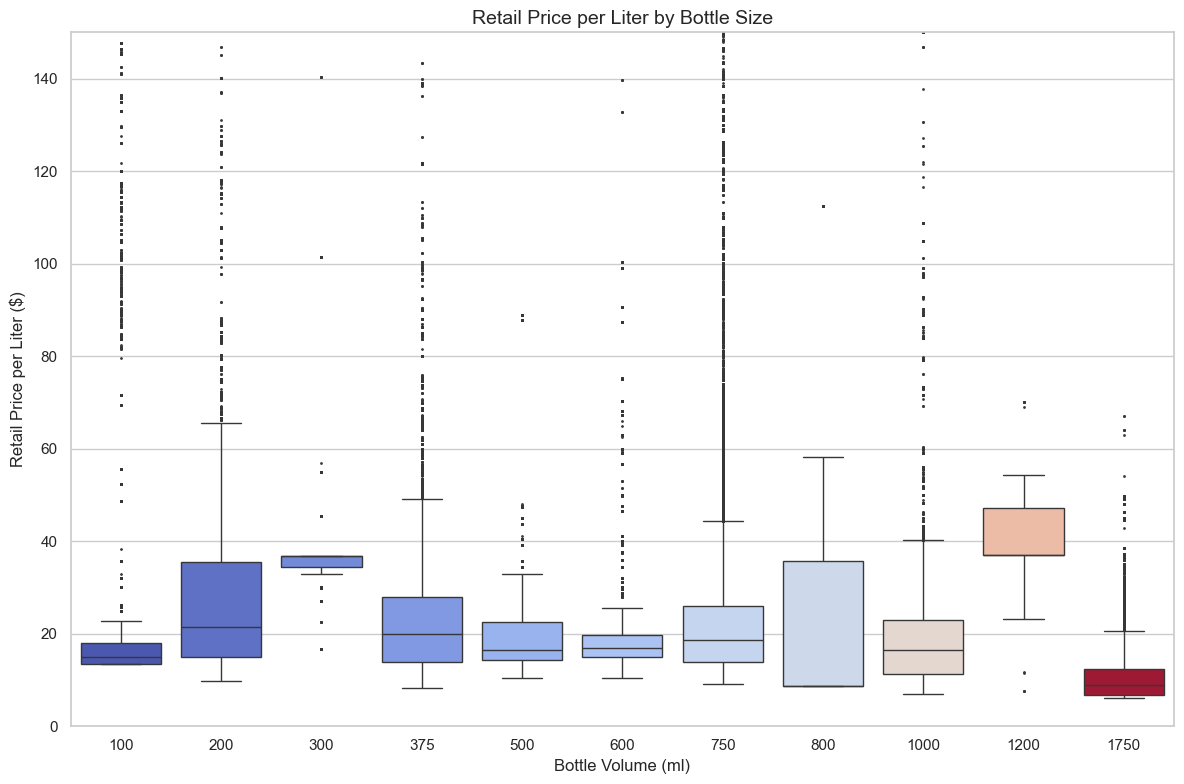

In [ ]:
# Set style
sns.set(style="whitegrid")

# Focus on common sizes
sizes_to_plot = [100, 200, 300, 375, 500, 600, 750, 800, 1000, 1200, 1750]
filtered = liquor_df_clean[liquor_df_clean['Bottle Volume (ml)'].isin(sizes_to_plot)]

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=filtered,
    x='Bottle Volume (ml)',
    y='Retail Price per Liter',
    hue='Bottle Volume (ml)',
    palette='coolwarm',
    linewidth=1,
    fliersize=1,
    legend=False
)
plt.ylim(0, 150)
plt.title('Retail Price per Liter by Bottle Size', fontsize=14)
plt.xlabel('Bottle Volume (ml)', fontsize=12)
plt.ylabel('Retail Price per Liter ($)', fontsize=12)
plt.tight_layout()
plt.show()

In [22]:
pd.set_option('display.float_format', '{:,.6f}'.format)

# Extract lat and lon with full precision
def extract_lat_lon(loc):
    match = re.search(r'\(([-\d.]+),\s*([-\d.]+)\)', str(loc))
    if match:
        lat_str, lon_str = match.group(1), match.group(2)
        return float(lat_str), float(lon_str)
    return None, None

liquor_df_clean['Latitude'], liquor_df_clean['Longitude'] = zip(*liquor_df_clean['Store Location'].map(extract_lat_lon))

# Drop rows without coordinates
liquor_df_clean = liquor_df_clean.dropna(subset=['Latitude', 'Longitude']).copy()

In [23]:
# Keep only entries with valid coordinates within Iowa
liquor_df_clean = liquor_df_clean[
    (liquor_df_clean['Latitude'] >= 40.3) & (liquor_df_clean['Latitude'] <= 43.5) &
    (liquor_df_clean['Longitude'] >= -96.6) & (liquor_df_clean['Longitude'] <= -90.1)
].copy()

In [24]:
# Drop duplicate store locations
unique_stores = liquor_df_clean[['Latitude', 'Longitude', 'Store Name']].drop_duplicates()

# Start map centered on Iowa
map_center = [42.0, -93.0]
store_map = folium.Map(location=map_center, zoom_start=7)

# Add unique store points to the map
for _, row in unique_stores.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=row['Store Name']
    ).add_to(store_map)

# Save to HTML
store_map.save('iowa_liquor_stores.html')

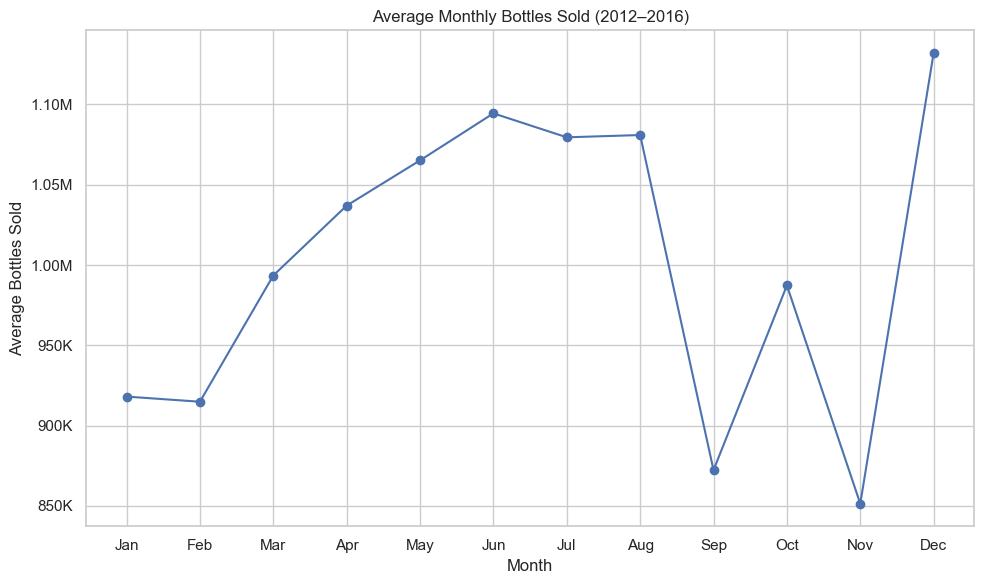

In [25]:
# Filter to 2012–2016
mask = (liquor_df_clean['Date'] >= '2012-01-01') & (liquor_df_clean['Date'] <= '2016-12-31')
filtered = liquor_df_clean[mask].copy()

# Extract month and year
filtered['Year'] = filtered['Date'].dt.year
filtered['Month'] = filtered['Date'].dt.month

# Group by year and month to get total bottles sold
monthly = (
    filtered.groupby(['Year', 'Month'])['Bottles Sold']
    .sum()
    .reset_index()
)

# Average bottles sold per calendar month across years
monthly_avg = (
    monthly.groupby('Month')['Bottles Sold']
    .mean()
    .reset_index()
)

# Format y-axis to use K (thousands)
def format_thousands(x, _):
    if x >= 1_000_000:
        return f'{x/1_000_000:.2f}M'
    return f'{int(x/1_000)}K'

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg['Month'], monthly_avg['Bottles Sold'], marker='o')
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.title('Average Monthly Bottles Sold (2012–2016)')
plt.xlabel('Month')
plt.ylabel('Average Bottles Sold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))
plt.grid(True)
plt.tight_layout()
plt.show()

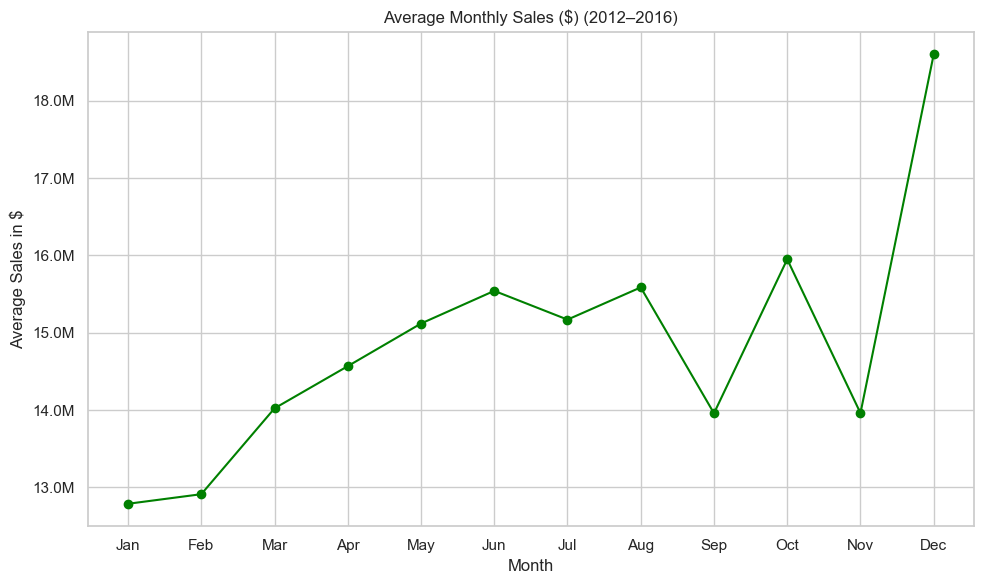

In [26]:
# Filter to 2012–2016
mask = (liquor_df_clean['Date'] >= '2012-01-01') & (liquor_df_clean['Date'] <= '2016-12-31')
filtered = liquor_df_clean[mask].copy()

# Extract month and year
filtered['Year'] = filtered['Date'].dt.year
filtered['Month'] = filtered['Date'].dt.month

# Group by year and month to get total sales in dollars
monthly = (
    filtered.groupby(['Year', 'Month'])['Sale (Dollars)']
    .sum()
    .reset_index()
)

# Average sales per calendar month across years
monthly_sales = (
    monthly.groupby('Month')['Sale (Dollars)']
    .mean()
    .reset_index()
)

# Format y-axis to use K (thousands)
def format_thousands(x, _):
    if x >= 1_000_000:
        return f'{x/1_000_000:}M'
    return f'{int(x/1_000)}K'

plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['Month'], monthly_sales['Sale (Dollars)'], marker='o', color='green')
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.title('Average Monthly Sales ($) (2012–2016)')
plt.xlabel('Month')
plt.ylabel('Average Sales in $')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))
plt.grid(True)
plt.tight_layout()
plt.show()

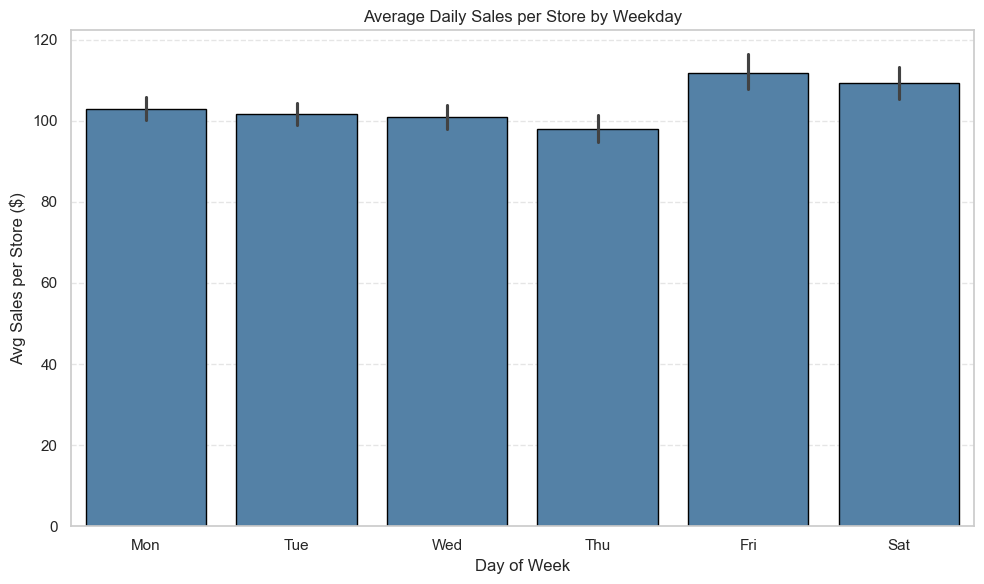

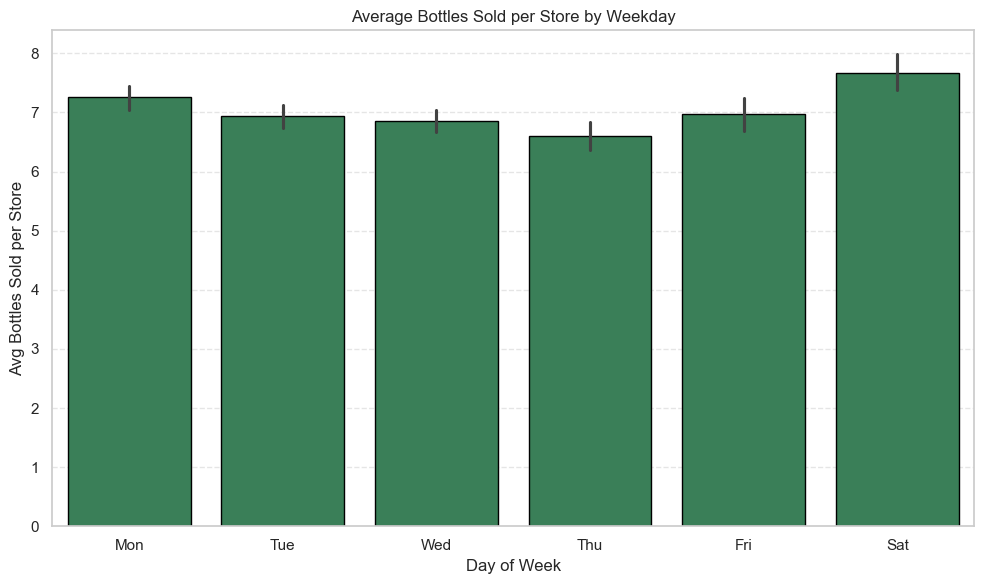

In [28]:
# Extract day of week (0 = Mon, 6 = Sun)
liquor_df_clean['Day'] = liquor_df_clean['Date'].dt.dayofweek

# Filter out Sundays (day 6)
weekday_df = liquor_df_clean[liquor_df_clean['Day'] < 6].copy()

# Map day numbers to names
day_labels = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat'}
weekday_df['Day Name'] = weekday_df['Day'].map(day_labels)

# Group by store and day, then calculate per-store average sales and bottles
per_store_day = (
    weekday_df.groupby(['Store Name', 'Day Name'])[['Sale (Dollars)', 'Bottles Sold']]
    .mean()
    .reset_index()
)

# --- Plot sales ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=per_store_day,
    x='Day Name',
    y='Sale (Dollars)',
    order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    errorbar=('ci', 95),
    color='steelblue',
    edgecolor='black'
)
plt.title('Average Daily Sales per Store by Weekday')
plt.ylabel('Avg Sales per Store ($)')
plt.xlabel('Day of Week')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot bottles sold ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=per_store_day,
    x='Day Name',
    y='Bottles Sold',
    order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    errorbar=('ci', 95),
    color='seagreen',
    edgecolor='black'
)
plt.title('Average Bottles Sold per Store by Weekday')
plt.ylabel('Avg Bottles Sold per Store')
plt.xlabel('Day of Week')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Aggregate total sales per store with valid coordinates
store_sales = (
    liquor_df_clean
    .dropna(subset=['Latitude', 'Longitude'])
    .groupby(['Store Name', 'Latitude', 'Longitude'])['Sale (Dollars)']
    .sum()
    .reset_index()
)

# Normalize sales for better heatmap visibility (optional, clip extremes)
store_sales['Weight'] = store_sales['Sale (Dollars)'].clip(upper=1_000_000) / 1_000_000

# Create map
sales_map = folium.Map(location=[42.0, -93.0], zoom_start=7)

# Add heatmap layer
HeatMap(
    data=store_sales[['Latitude', 'Longitude', 'Weight']].values,
    radius=10,
    blur=15,
    max_zoom=10
).add_to(sales_map)

# Save as a HTML
sales_map.save('iowa_sales_heatmap.html')

---

## Weekly Liquor Sales per County Prediction Using LightGMB

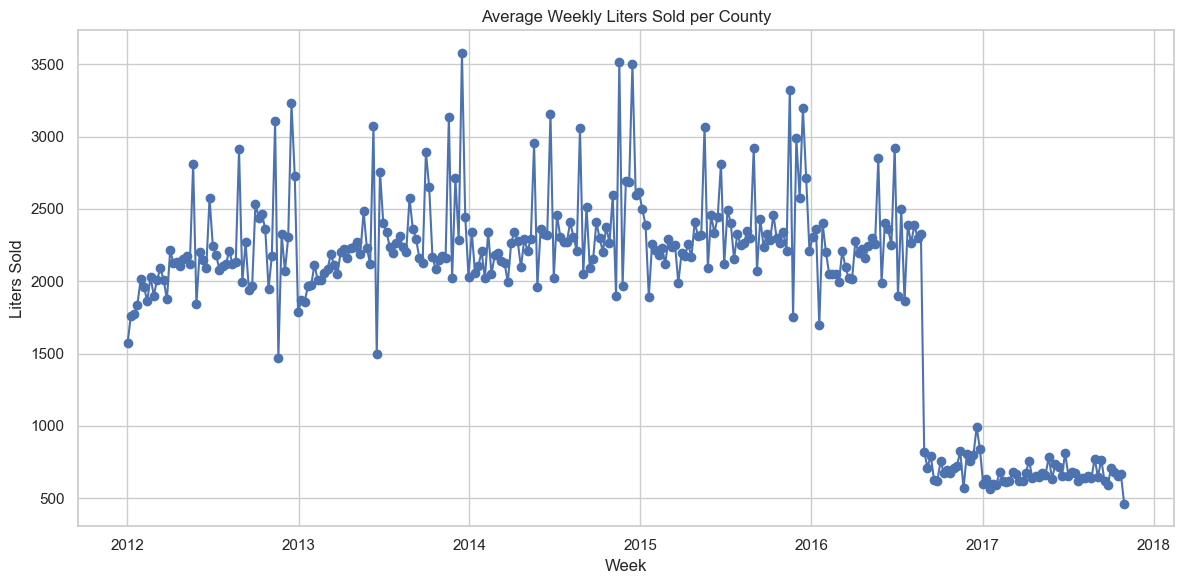

In [ ]:
# Copy and convert to weekly period
weekly = liquor_df_clean.copy()
weekly['Week'] = weekly['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Compute liters sold
weekly['Liters Sold'] = (weekly['Bottle Volume (ml)'] * weekly['Bottles Sold']) / 1000

# Group by Week and County, then compute total liters sold per county per week
weekly_county = (
    weekly.groupby(['Week', 'County'])['Liters Sold']
    .sum()
    .reset_index()
)

# Average liters sold per county each week
weekly_avg = (
    weekly_county.groupby('Week')['Liters Sold']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 6))
plt.plot(weekly_avg['Week'], weekly_avg['Liters Sold'], marker='o', linestyle='-')
plt.title('Average Weekly Liters Sold per County')
plt.xlabel('Week')
plt.ylabel('Liters Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Create 'Week' column and compute weekly liters sold
weekly_df = liquor_df_clean.copy()
weekly_df['Week'] = weekly_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_df['Liters Sold'] = (weekly_df['Bottle Volume (ml)'] * weekly_df['Bottles Sold']) / 1000

# Step 2: Aggregate by County and Week
weekly_agg = (
    weekly_df.groupby(['County', 'Week'])
    .agg({
        'Bottle Volume (ml)': 'mean',
        'State Bottle Retail': 'mean',
        'Liters Sold': 'sum',
        'Date': 'count'  # proxy for transaction count
    })
    .rename(columns={'Date': 'Transaction Count'})
    .reset_index()
)

# Step 3: Feature engineering
weekly_agg['Month'] = weekly_agg['Week'].dt.month
weekly_agg['Year'] = weekly_agg['Week'].dt.year

# Step 4: Encode only categorical variables
weekly_agg['County'] = LabelEncoder().fit_transform(weekly_agg['County'])

# Step 5: Define features and target
features = [
    'Bottle Volume (ml)',
    'State Bottle Retail',
    'Month',
    'Year',
    'County',
    'Transaction Count'
]
target = 'Liters Sold'

# Step 6: Prepare full X and y
X = weekly_agg[features + ['Week']].copy()
y = weekly_agg[target]

# Step 7: Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Save 'Week' and 'County' for post-prediction merge
X_valid_weeks = X_valid['Week'].copy()
X_valid_counties = X_valid['County'].copy()

# Step 9: Drop 'Week' before feeding into model
X_train = X_train.drop(columns=['Week'])
X_valid = X_valid.drop(columns=['Week'])

In [40]:
# Prepare LightGBM datasets
train_set = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=['Month', 'County']
)
valid_set = lgb.Dataset(
    X_valid, label=y_valid,
    categorical_feature=['Month', 'County']
)

# Train the model
model = lgb.train(
    {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'n_jobs': -1
    },
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=10000,
    callbacks=[early_stopping(stopping_rounds=20, verbose=False)]
)

# Predict and evaluate
y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f'RMSE: {rmse:,.2f}')
print(f'MAE: {mae:,.2f}')
print(f'R²: {r2:.4f}')
print(f'Best iteration: {model.best_iteration}')


RMSE: 567.14
MAE: 160.25
R²: 0.9857
Best iteration: 186


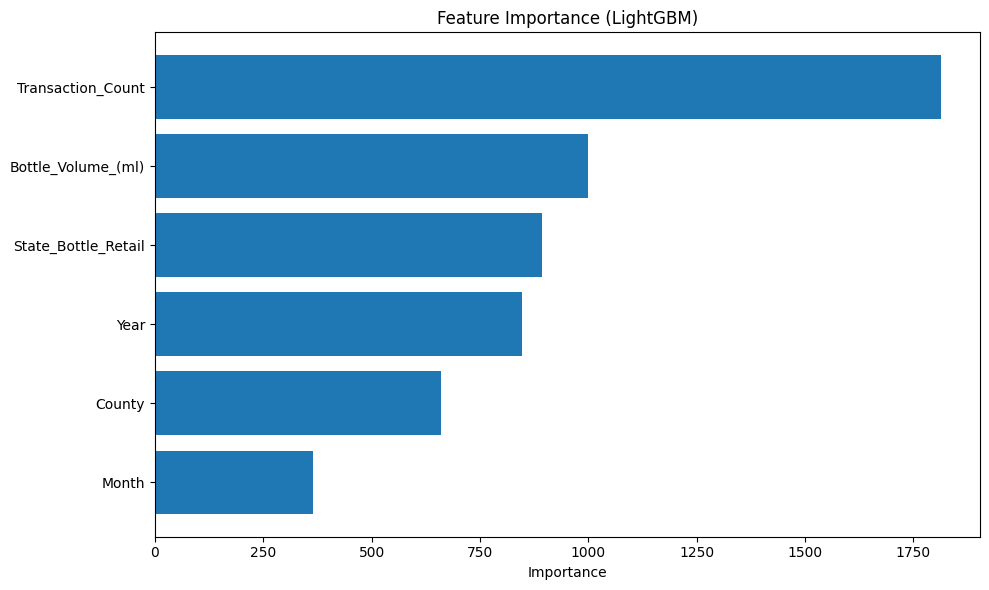

In [41]:
# Get feature names and importances
importance = model.feature_importance()
features = model.feature_name()

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

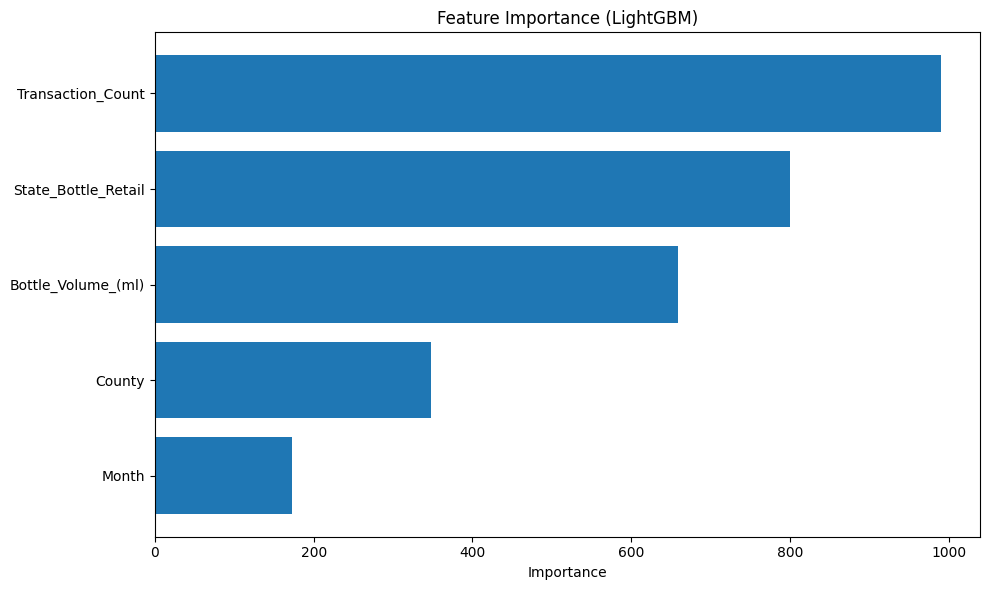

In [22]:
# Get feature names and importances
importance = model.feature_importance()
features = model.feature_name()

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

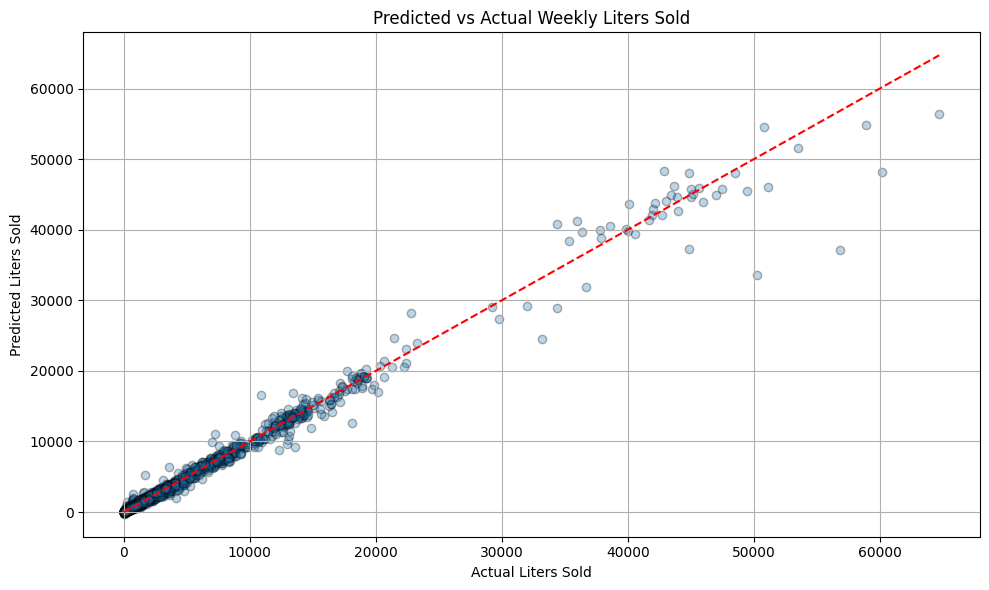

Number of validation points (dots in scatter plot): 5841


In [48]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.title('Predicted vs Actual Weekly Liters Sold')
plt.xlabel('Actual Liters Sold')
plt.ylabel('Predicted Liters Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of validation points (dots in scatter plot): {len(y_valid)}")

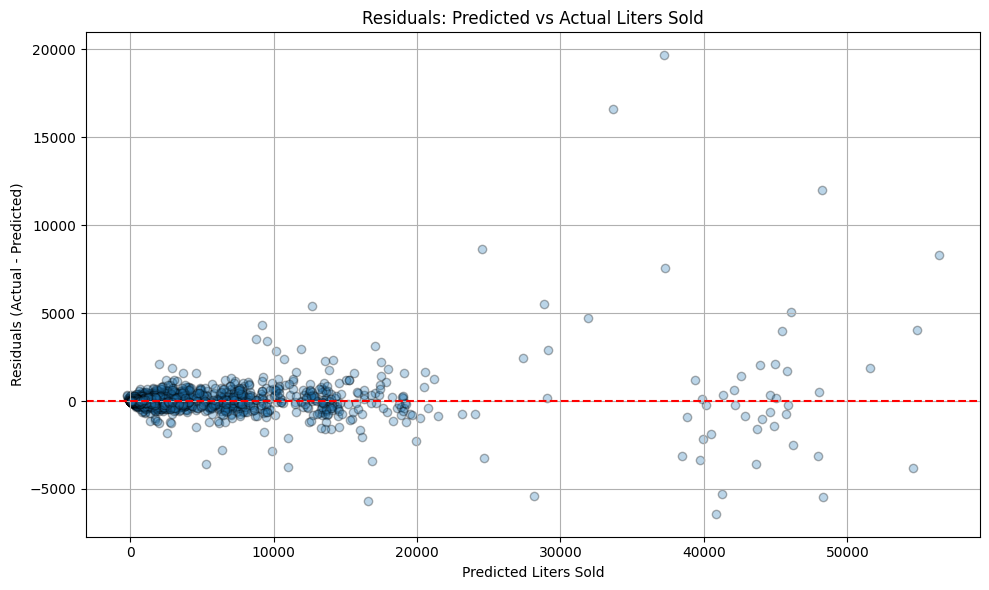

In [47]:
# Calculate residuals
residuals = y_valid - y_pred

# Residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals: Predicted vs Actual Liters Sold')
plt.xlabel('Predicted Liters Sold')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()

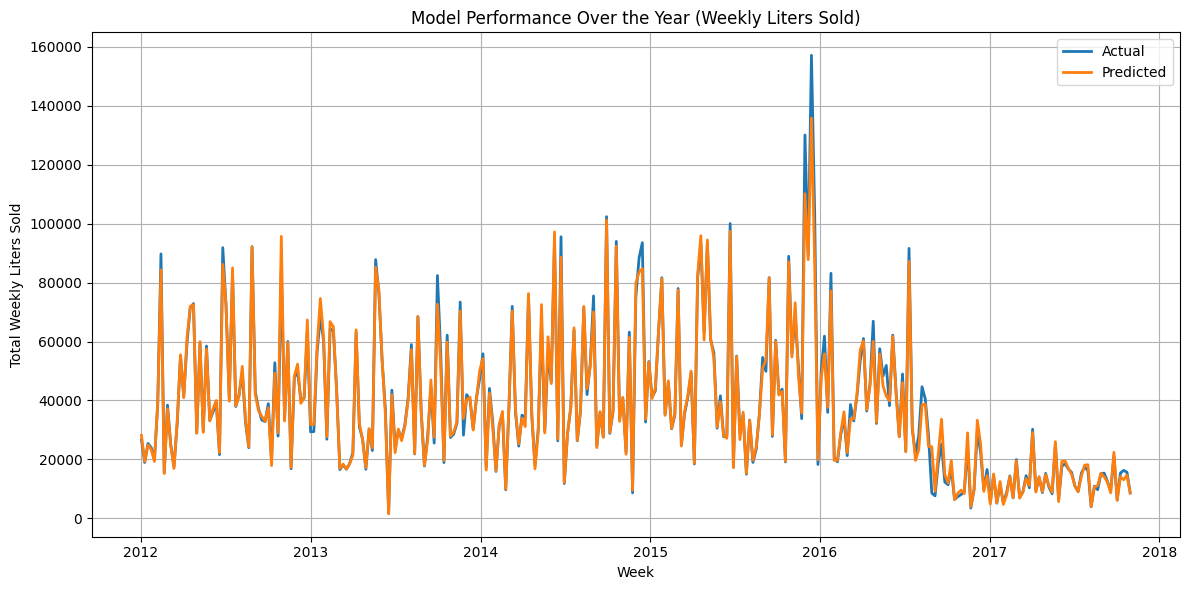

In [45]:
# Add predictions back to validation set
valid_results = X_valid.copy()
valid_results['Actual'] = y_valid.values
valid_results['Predicted'] = y_pred

# Add corresponding week info from original data
valid_results = valid_results.merge(
    weekly_agg[['County', 'Week']], 
    left_index=True, right_index=True, 
    how='left'
)

# Group by Week: sum predicted and actual liters
weekly_perf = (
    valid_results.groupby('Week')[['Actual', 'Predicted']]
    .sum()
    .reset_index()
    .sort_values('Week')
)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_perf['Week'], weekly_perf['Actual'], label='Actual', linewidth=2)
plt.plot(weekly_perf['Week'], weekly_perf['Predicted'], label='Predicted', linewidth=2)
plt.title('Model Performance Over the Year (Weekly Liters Sold)')
plt.xlabel('Week')
plt.ylabel('Total Weekly Liters Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Merge predictions with X_valid info
results_df = X_valid.copy()
results_df['Actual Liters Sold'] = y_valid.values
results_df['Predicted Liters Sold'] = y_pred
results_df['Residual'] = results_df['Actual Liters Sold'] - results_df['Predicted Liters Sold']
results_df['Week'] = X_valid_weeks.values
results_df['County'] = X_valid_counties.values

# Re-attach the 'Year' column for inspection
results_df['Year'] = results_df['Week'].dt.year

# Sort for visual check
sample = (
    results_df
    .sort_values(['County', 'Year', 'Week'])
    .groupby(['County', 'Year'])
    .head(5)  # show 5 predictions per county-year combo
    .reset_index(drop=True)
)

# Display sample
sample[['County', 'Year', 'Week', 'Actual Liters Sold', 'Predicted Liters Sold', 'Residual']]


,County,Year,Week,Actual Liters Sold,Predicted Liters Sold,Residual
0,0,2012,2012-01-23,384.62,413.73,-29.11
1,0,2012,2012-02-13,315.38,341.38,-26.00
2,0,2012,2012-04-30,466.77,502.76,-35.99
3,0,2012,2012-07-23,459.30,482.08,-22.78
4,0,2012,2012-08-27,496.57,511.73,-15.16
...,...,...,...,...,...,...
2953,102,2017,2017-01-23,294.32,299.04,-4.72
2954,102,2017,2017-06-19,265.38,271.27,-5.89
2955,102,2017,2017-06-26,270.52,230.46,40.06
2956,102,2017,2017-07-24,188.25,217.39,-29.14
